In [1]:
import requests
from datetime import datetime, timedelta
import pandas as pd
from IPython.display import Markdown as md

# Sunshine Live Charts - Analyse

Aus gegebenem Anlass stellt sich die Frage: Wie arg wiederholt sich die Playlist von Sunshine Live Charts eigentlich wirklich?

## Rohdaten

Die Playlist kann von der Sunshine Live Webseite per API abgefragt werden.

In [2]:
endpoint = "https://iris-sunshinelive.loverad.io/search.json"
delta_t = pd.Timedelta(1, 'W')
params = {
    'station': 24,
    'start': pd.Timestamp('2021-09-20T00:00:00+0200'),
    'end': pd.Timestamp('2021-09-20T00:00:00+0200') + delta_t
}
res = requests.get(endpoint, params=params)

Die Rohdaten können jetzt mit Pandas eingelesen und aufbereitet werden.

In [3]:
df = pd.json_normalize(res.json()['result']['entry'], 
                       record_path=['song', 'entry'], 
                       meta=[ 'airtime' ])
df = df[['title', 'airtime']]
df['airtime'] = pd.to_datetime(df['airtime'])

Und so sehen unsere Daten dann aus:

In [4]:
df.head()

,title,airtime
0,Day 'n' Nite (Martin Jensen Edit),2021-09-26 23:58:42+02:00
1,Never Let Me Down,2021-09-26 23:56:10+02:00
2,Sweet Dreams (Are Made of This),2021-09-26 23:53:45+02:00
3,Hypercolour,2021-09-26 23:50:23+02:00
4,ily (i love you baby) (ARTY Remix),2021-09-26 23:47:21+02:00


### Eckdaten

In [5]:
md('''
Der Datensatz besteht aus {} Beobachtungen und umfasst einen Zeitraum von {}.
In diesem Zeitraum wurden **{} verschiedene** Lieder gespielt.'''.format(len(df), params['end'] - params['start'], df['title'].nunique()))


Der Datensatz besteht aus 3430 Beobachtungen und umfasst einen Zeitraum von 7 days 00:00:00.
In diesem Zeitraum wurden **30 verschiedene** Lieder gespielt.

## Häufigkeitsanalyse

Wie oft wurde welches Lied im Auswertungszeitraum gespielt?

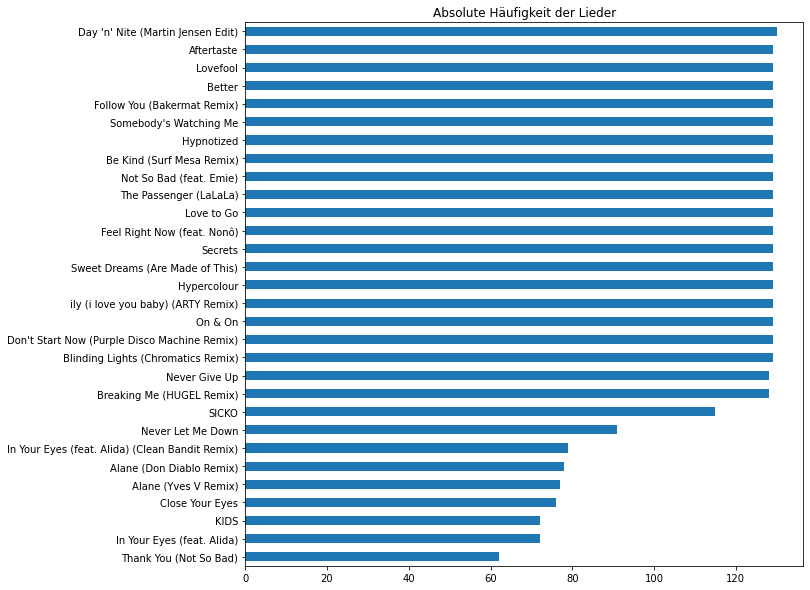

In [6]:
freq = df['title'].value_counts()
freq.plot(kind='barh', title="Absolute Häufigkeit der Lieder", figsize=(10,10)).invert_yaxis()

Daraus ergibt sich eine relative Häufigkeit jedes Liedes pro Tag:

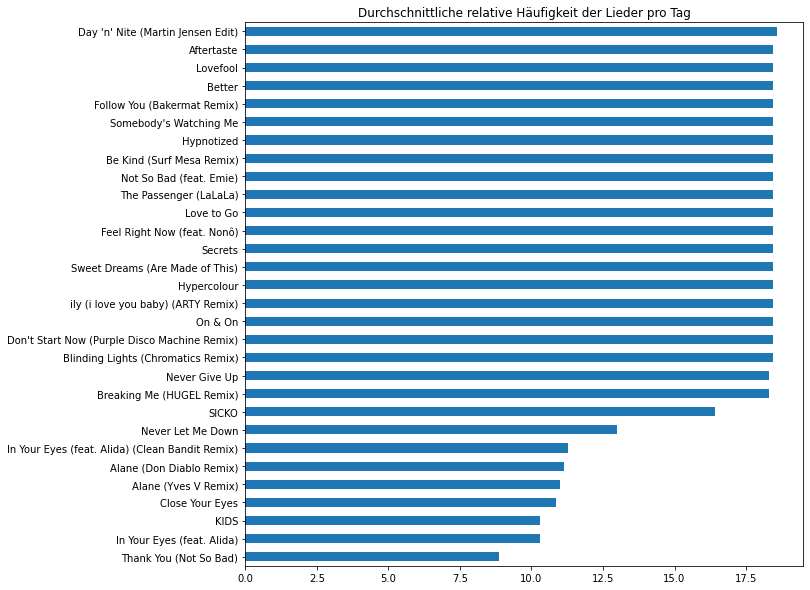

In [7]:
freq_per_day = freq / (delta_t.total_seconds() / (3600 * 24))
freq_per_day.plot(kind='barh', title="Durchschnittliche relative Häufigkeit der Lieder pro Tag", figsize=(10,10)).invert_yaxis()

Im Umkehrschluss lässt sich die durchschnittliche Periodendauer jedes Liedes abschätzen, also die Zeitdauer nach der ein bestimmtes Lieder erneut gespielt wird.

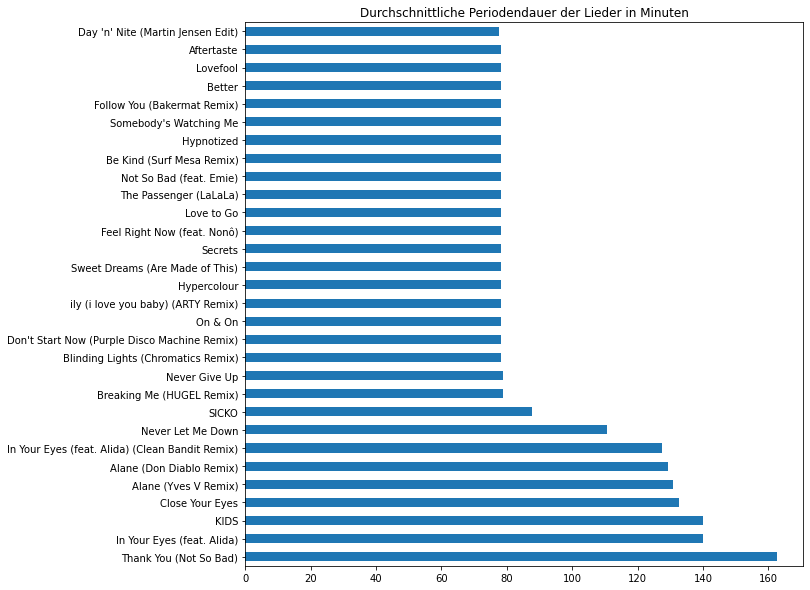

In [8]:
freq_per_minute = freq / (delta_t.total_seconds() / 60)
period_in_m = 1 / freq_per_minute
period_in_m.plot(kind='barh', title="Durchschnittliche Periodendauer der Lieder in Minuten", figsize=(10,10)).invert_yaxis()

## Zwischenfazit

In [9]:
md('''Das Programm von SSL Charts besteht aus {} Liedern und wiederholt sich durchschnittlich alle **{:2.0f}** Minuten!'''.format(df['title'].nunique(), period_in_m.mean()))

Das Programm von SSL Charts besteht aus 30 Liedern und wiederholt sich durchschnittlich alle **93** Minuten!

(Durchschnittswerte basierend auf der Gesamtmenge. Detailbetrachtung je Lied folgt.)

### Rotation

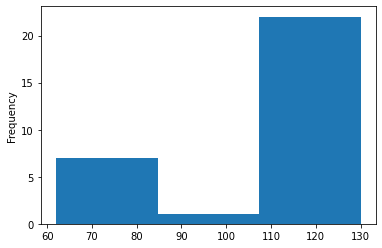

In [10]:
freq.plot(kind='hist',bins=3);

Klar zu erkennen ist die *Hot Rotation*, bestehend aus 21 Songs, eine kleine *Medium Rotation* von zwei Liedern und sieben Lieder in der *Low Rotation*.

## Detailbetrachtung

Machen wir es genauer und ermitteln der Differenz zwischen den Spielzeiten je Lied.

In [11]:
df.sort_values(['title', 'airtime'], inplace=True)
df['period'] = df['airtime'].diff()

In [12]:
mask = df.title != df.title.shift(1)
df['period'][mask] = pd.NaT
df.dropna(inplace=True)
df['period'] = df.period.dt.seconds / 60

/tmp/ipykernel_225/3984654730.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['period'][mask] = pd.NaT


In [13]:
df['period'].mean()

87.95305392156843

Die mittlere Periodendauer über alle Lieder liegt etwas niedriger als die erste Abschätzung.

Heruntergebrochen auf die einzelnen Lieder zeigt sich wieder die Verteilung auf die Hot-/Medium-/Low-Rotation:

In [14]:
df.groupby('title').mean()

,period
title,
Aftertaste,78.285286
Alane (Don Diablo Remix),128.295022
Alane (Yves V Remix),132.007018
Be Kind (Surf Mesa Remix),78.224740
Better,78.135026
Blinding Lights (Chromatics Remix),78.222005
Breaking Me (HUGEL Remix),78.308924
Close Your Eyes,131.925333
Day 'n' Nite (Martin Jensen Edit),78.088630


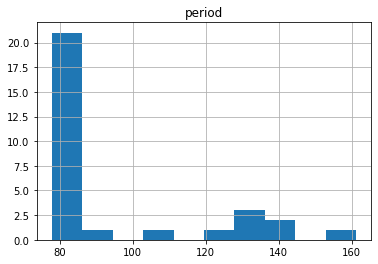

In [15]:
df.groupby('title').mean().hist();

Mehr als 20 der 30 Lieder wiederholen sich nach durchschnittlich 83 Minuten.

Schauen wir uns die Verteilung der Zeitabstände im Detail an:

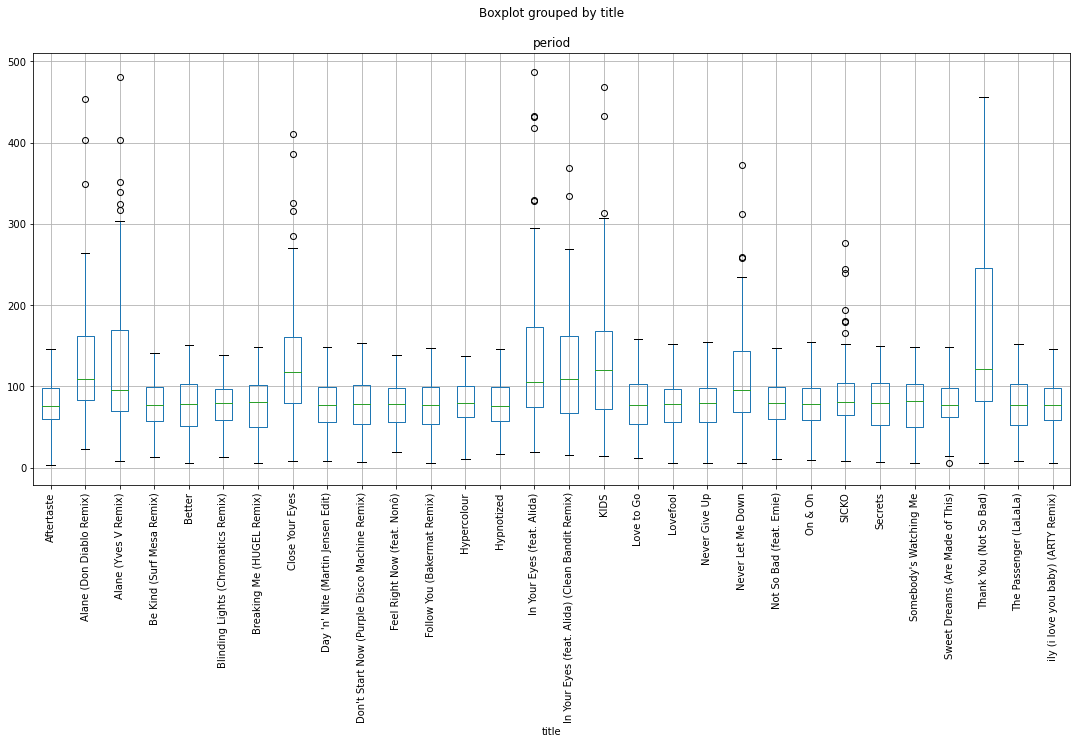

In [16]:
df.boxplot(column='period', by='title', figsize=(18,8), rot=90.0);

Bei den meisten Liedern liegt das Minimum alarmierend nahe an der Null, was bedeutet, dass diese Lieder in Einzelfällen fast direkt hintereinander erneut gespielt wurden!
Der Mittelwert liegt dabei in etwa auf dem Niveau von 85 Minuten mit geringer Streubreite.

## Fazit

Mit 30 Liedern nicht gerade abwechslungsreiches Programm.